In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils import load_dataset

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [3]:
df_creibles = load_dataset("data/junio23.csv", 15)

In [4]:
X = df_creibles.drop("fallecio", axis=1)
y = df_creibles["fallecio"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0, stratify=y)
print(X_train.shape)
print(X_test.shape)

(136086, 14)
(34022, 14)


## Revisar cuantos datos son incorregibles en test
Como las columnas son pocas, ocurre que pacientes con las mismas caracteristicas, tengan outcomes distintos. Vamos a ver cuantos

In [6]:
df_creibles_test = X_test.copy(deep=True)
df_creibles_test["fallecio"] = y_test

In [7]:
from collections import Counter
inputs = [list(a) for a in df_creibles_test.values]
df_gr = pd.DataFrame(Counter([tuple(i) for i in inputs]), index=[0]).T.rename(columns={0:"cuenta"}).sort_values("cuenta", ascending=False).reset_index(-1)
df_gr2 = df_gr.groupby(df_gr.index).count()
errors = list(df_gr2[df_gr2["cuenta"]>1].index)
err_an = df_gr.loc[errors,:]
err_an["mean_group"] = err_an.groupby(err_an.index)["cuenta"].transform("mean")
err_an["std_group"] = err_an.groupby(err_an.index)["cuenta"].transform("std")
err_an = err_an[err_an["mean_group"] > 10]
err_an["indice_disp"] = err_an["mean_group"] / (err_an["std_group"] + 0.7)
err_an = err_an.sort_values("indice_disp", ascending = False)
err_an.groupby(err_an.index)["cuenta"].min().values.sum()

926

926 de 34022, es decir, cerca del 3% de los registros en test

## Carga de modelo descalibrado y calibrado

In [8]:
lgbm_clf = joblib.load('models/lgbm_binary_auc_20200626-110602.pkl')

In [9]:
cc_clf = joblib.load('models/sigmoid_20200626-110814.pkl')

In [10]:
y_pred = lgbm_clf.predict(X_test)
y_scores = lgbm_clf.predict_proba(X_test)[:,1]

In [11]:
y_pred_cal = cc_clf.predict(X_test)
y_scores_cal = cc_clf.predict_proba(X_test)[:,1]

In [12]:
print(f"""
AUC en modelo descalibrado: {roc_auc_score(y_test, y_scores)}
AUC en modelo calibrado: {roc_auc_score(y_test, y_scores_cal)}

""")


AUC en modelo descalibrado: 0.8853665586974393
AUC en modelo calibrado: 0.8852884902567517




No hay una diferencia significativa, podemos proceder

## Diferencia enetre curva descalibrada y calibrada

In [13]:
cc = calibration_curve(y_test, y_scores, n_bins=10)

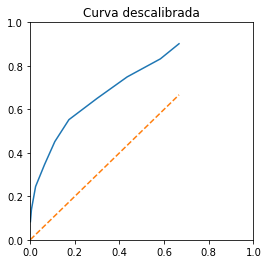

In [14]:
plt.figure(figsize=(4,4))
plt.plot(cc[0], cc[1])
plt.plot(cc[0], cc[0], "--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("Curva descalibrada")
plt.show()

In [15]:
cc_cal = calibration_curve(y_test, y_scores_cal, n_bins=10)

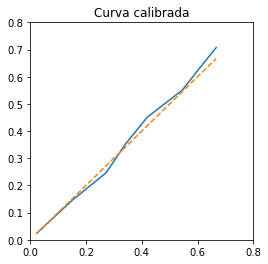

In [16]:
plt.figure(figsize=(4,4))
plt.plot(cc_cal[0], cc_cal[1])
plt.plot(cc_cal[0], cc_cal[0], "--")
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.title("Curva calibrada")
plt.show()

# Histograma entre clases para diferenciar el modelo descalibrado y calibrado

In [17]:
df = pd.DataFrame({"scores":y_scores, "scores_cal": y_scores_cal, "real":y_test})
df_0 = df[df["real"]==0]
df_1 = df[df["real"]==1]

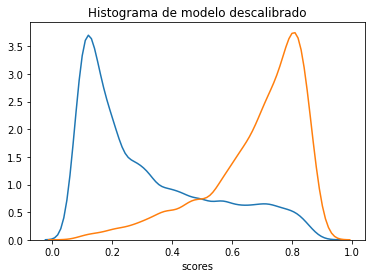

In [18]:
sns.distplot(df_0["scores"], hist=False)
sns.distplot(df_1["scores"], hist=False)
plt.title("Histograma de modelo descalibrado")
plt.show()

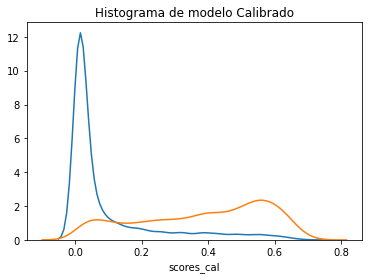

In [19]:
sns.distplot(df_0["scores_cal"], hist=False)
sns.distplot(df_1["scores_cal"], hist=False)
plt.title("Histograma de modelo Calibrado")
plt.show()

### Conclusion: Nos quedamos con el modelo calibrado

## Curva roc del modelo calibrado

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.885


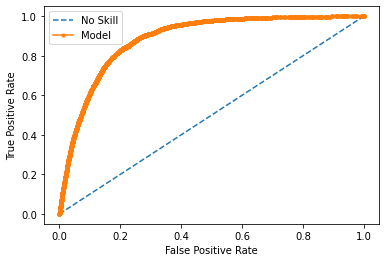

In [20]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_scores_cal)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_scores_cal)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Importancia de las variables del modelo

In [21]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_clf.feature_importances_,X_test.columns), reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,1426,EDAD
1,199,INMUSUPR
2,197,OBESIDAD
3,174,CARDIOVASCULAR
4,173,TABAQUISMO
5,159,OTRA_COM
6,140,EMBARAZO
7,128,EPOC
8,105,HIPERTENSION
9,89,RENAL_CRONICA


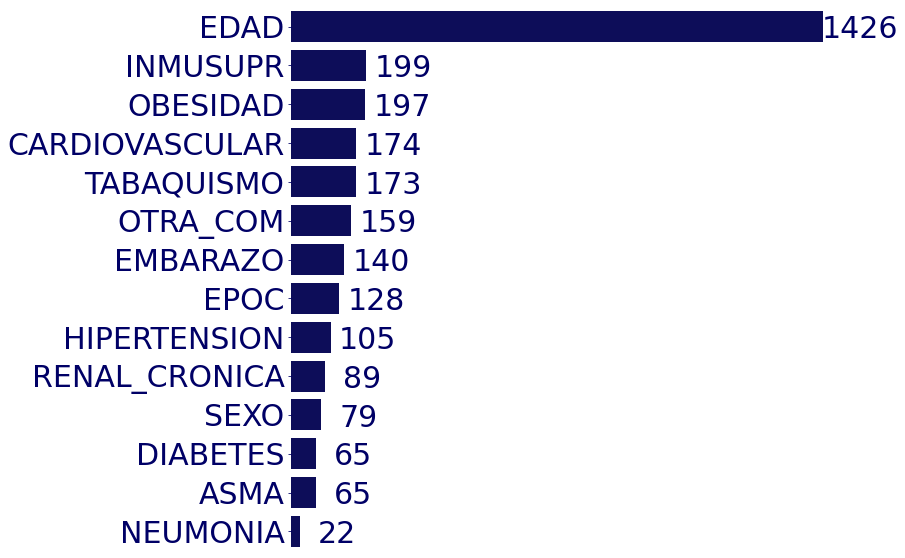

In [22]:
plt.figure(figsize=(10,10))
color = "#000066"
ax = sns.barplot(y="Feature", x="Value", data=feature_imp, palette=[color], orient="h")

plt.grid(False)

ax.set_xlabel("", fontsize=30)
plt.xticks([])
plt.box(False)
ax.set_ylabel("", fontsize=30)

ax.tick_params(axis='y',which = "major", colors=color)



# jugar con estos valores
vertical_offset = 0.3
horizontal_offset = 100

ax.tick_params(axis='both', which='major', labelsize=30)
for index, row in feature_imp.iterrows():
    ax.text(row["Value"] + horizontal_offset,index+vertical_offset, # posicion
            row["Value"], # texto
            color=color, 
            ha="center", 
            size=30)
    
# plt.savefig(f'importances.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()